In [1]:
# Data Handling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set styles
sns.set(style="whitegrid")


In [4]:
# Load the dataset
df = pd.read_csv('C:\\Users\\M S I\\Desktop\\Crop_harvest_forecast_app\\data\\crop_yield.csv')

# Show basic info
print("Shape:", df.shape)
print(df.head())
print("\nMissing values:\n", df.isnull().sum())


Shape: (19689, 10)
           Crop  Crop_Year       Season  State     Area  Production  \
0      Arecanut       1997  Whole Year   Assam  73814.0       56708   
1     Arhar/Tur       1997  Kharif       Assam   6637.0        4685   
2   Castor seed       1997  Kharif       Assam    796.0          22   
3      Coconut        1997  Whole Year   Assam  19656.0   126905000   
4  Cotton(lint)       1997  Kharif       Assam   1739.0         794   

   Annual_Rainfall  Fertilizer  Pesticide        Yield  
0           2051.4  7024878.38   22882.34     0.796087  
1           2051.4   631643.29    2057.47     0.710435  
2           2051.4    75755.32     246.76     0.238333  
3           2051.4  1870661.52    6093.36  5238.051739  
4           2051.4   165500.63     539.09     0.420909  

Missing values:
 Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield

In [5]:
# Remove unnecessary column
df = df.drop(columns=['Crop_Year'], errors='ignore')

# Ensure categorical columns are strings
for col in ['Crop', 'Season', 'State']:
    df[col] = df[col].astype(str)

# Handle missing values (if any in the future)
df.fillna(df.median(numeric_only=True), inplace=True)


In [6]:
# Cap extreme outliers in Yield to remove unrealistic values
yield_cap = df['Yield'].quantile(0.99)
df = df[df['Yield'] <= yield_cap]

# New ratio-based features
df['Fertilizer_per_Area'] = df['Fertilizer'] / (df['Area'] + 1e-6)
df['Pesticide_per_Area'] = df['Pesticide'] / (df['Area'] + 1e-6)
df['Input_Intensity'] = (df['Fertilizer'] + df['Pesticide']) / (df['Area'] + 1e-6)

# Log-transform for skewed numeric features
log_cols = ['Area', 'Fertilizer', 'Pesticide', 'Fertilizer_per_Area', 'Pesticide_per_Area', 'Input_Intensity']
for col in log_cols:
    df[col + '_log'] = np.log1p(df[col])


In [7]:
# Features & Target
features = ['Crop', 'Season', 'State',
            'Area_log', 'Annual_Rainfall',
            'Fertilizer_log', 'Pesticide_log',
            'Fertilizer_per_Area_log', 'Pesticide_per_Area_log', 'Input_Intensity_log']

target = 'Yield'

# Categorical & Numerical separation
cat_features = ['Crop', 'Season', 'State']
num_features = [col for col in features if col not in cat_features]

# Train-test split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ('num', RobustScaler(), num_features)
])

# Complete pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20))
])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Crop', 'Season', 'State']),
                                                 ('num', RobustScaler(),
                                                  ['Area_log',
                                                   'Annual_Rainfall',
                                                   'Fertilizer_log',
                                                   'Pesticide_log',
                                                   'Fertilizer_per_Area_log',
                                                   'Pesticide_per_Area_log',
                                                   'Input_Intensity_log'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=200,
                                       random_state=42))])

In [9]:
# Predictions
y_pred = pipeline.predict(X_test)

# Metrics
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Mean Absolute Error (MAE): 0.86
Mean Squared Error (MSE): 5.78
Root Mean Squared Error (RMSE): 2.40
R² Score: 0.95


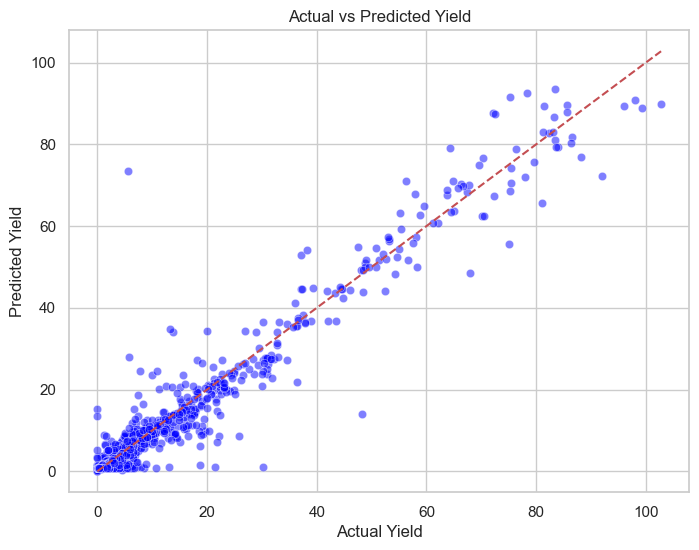

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.show()


In [11]:
# Optional: Randomized Search for better model
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                            n_iter=20, scoring='r2', cv=3, random_state=42, verbose=1, n_jobs=-1)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
pipeline = search.best_estimator_

# Retrain the best model
pipeline.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Crop', 'Season', 'State']),
                                                 ('num', RobustScaler(),
                                                  ['Area_log',
                                                   'Annual_Rainfall',
                                                   'Fertilizer_log',
                                                   'Pesticide_log',
                                                   'Fertilizer_per_Area_log',
                                                   'Pesticide_per_Area_log',
                                                   'Input_Intensity_log'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [12]:
# Final predictions
y_pred = pipeline.predict(X_test)

# Metrics
print(f"Improved MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Improved MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Improved RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Improved R² Score: {r2_score(y_test, y_pred):.2f}")


Improved MAE: 0.68
Improved MSE: 5.84
Improved RMSE: 2.42
Improved R² Score: 0.95


In [11]:
def create_input_df():
    print("\nEnter input values:")
    crop = input("Crop (e.g., Banana): ").strip()
    season = input("Season (e.g., Kharif): ").strip()
    state = input("State (e.g., Karnataka): ").strip()
    area = float(input("Area (hectares): "))
    annual_rainfall = float(input("Annual Rainfall (mm): "))
    fertilizer = float(input("Fertilizer used (kg): "))
    pesticide = float(input("Pesticide used (kg): "))

    fert_per_area = fertilizer / (area + 1e-6)
    pest_per_area = pesticide / (area + 1e-6)
    input_intensity = (fertilizer + pesticide) / (area + 1e-6)

    data = {
        'Crop': [crop],
        'Season': [season],
        'State': [state],
        'Area_log': [np.log1p(area)],
        'Annual_Rainfall': [annual_rainfall],
        'Fertilizer_log': [np.log1p(fertilizer)],
        'Pesticide_log': [np.log1p(pesticide)],
        'Fertilizer_per_Area_log': [np.log1p(fert_per_area)],
        'Pesticide_per_Area_log': [np.log1p(pest_per_area)],
        'Input_Intensity_log': [np.log1p(input_intensity)]
    }

    return pd.DataFrame(data)

# Make a prediction
input_df = create_input_df()
predicted_yield = pipeline.predict(input_df)[0]
print(f"\nPredicted Yield: {predicted_yield:.2f}")



Enter input values:
Crop (e.g., Banana): Rice
Season (e.g., Kharif): Kharif
State (e.g., Karnataka): Tamil Nadu
Area (hectares): 2500
Annual Rainfall (mm): 900
Fertilizer used (kg): 12500
Pesticide used (kg): 350

Predicted Yield: 2.83


In [13]:
import joblib

# Save the pipeline to the 'model' directory
joblib.dump(pipeline, 'model/pipeline.pkl')

print("✅ Model saved successfully at: model/pipeline.pkl")


✅ Model saved successfully at: model/pipeline.pkl
